# 3. EDA

# Prepare data - Jan 2015

In [23]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import contextily as ctx

In [24]:
# Connect to the database
con =  psycopg2.connect(dbname='carto', user='carto', password='carto', host='postgis', port='5432')

In [25]:
# Query to select only 10,000 pickup data from January
q_jan = '''
            SELECT tpep_pickup_datetime as pickup_time, pickup_point
            FROM taxi_geom
            WHERE tpep_pickup_datetime > '2014-12-31' AND tpep_pickup_datetime <'2015-03-01'
            LIMIT 10000;
        '''

# Save the query result as a geodataframe
pickup_jan = gpd.read_postgis(q_jan, con, geom_col='pickup_point')
pickup_jan.head()

,pickup_time,pickup_point
0,2015-01-01 15:00:38,POINT (-73.99344 40.74987)
1,2015-01-01 15:00:38,POINT (-73.99348 40.76223)
2,2015-01-01 15:00:38,POINT (-73.98643 40.73026)
3,2015-01-01 15:00:38,POINT (-73.94453 40.77927)
4,2015-01-01 15:00:39,POINT (-73.98162 40.78023)


In [26]:
if con:
    con.close()

In [27]:
pickup_jan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   10000 non-null  datetime64[ns]
 1   pickup_point  10000 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1)
memory usage: 156.4 KB


In [28]:
# Remove missing values if exist
pickup_jan = pickup_jan[~pickup_jan.isnull()]
pickup_jan.shape

(10000, 2)

In [29]:
# Remove duplicated rows
pickup_jan = pickup_jan[~pickup_jan.duplicated()]
pickup_jan.shape

(9999, 2)

In [30]:
print(pickup_jan.crs)

epsg:4326


# More data

* demographic & socio-economic data
* census block group geometries

In [31]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
demographic = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(demographic.shape)
demographic.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [32]:
# NYC census block group geometries
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')
print(census.crs)
census.head()

epsg:4326


,geoid,geometry
0,360050001001,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050002001,"POLYGON ((-73.86285 40.81267, -73.86191 40.812..."
2,360050002002,"POLYGON ((-73.86708 40.81444, -73.86332 40.812..."
3,360050002003,"POLYGON ((-73.85856 40.80665, -73.85848 40.806..."
4,360050004001,"POLYGON ((-73.85972 40.81527, -73.85956 40.815..."


In [33]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     6339 non-null   object  
 1   geometry  6339 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 99.2+ KB


In [34]:
# Change the data type of 'geoid' column
census.geoid = pd.to_numeric(census.geoid)
census.geoid.dtype

dtype('int64')

In [35]:
# Reproject data in Web mercator
pickup_jan = pickup_jan.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)

# Visualize the data

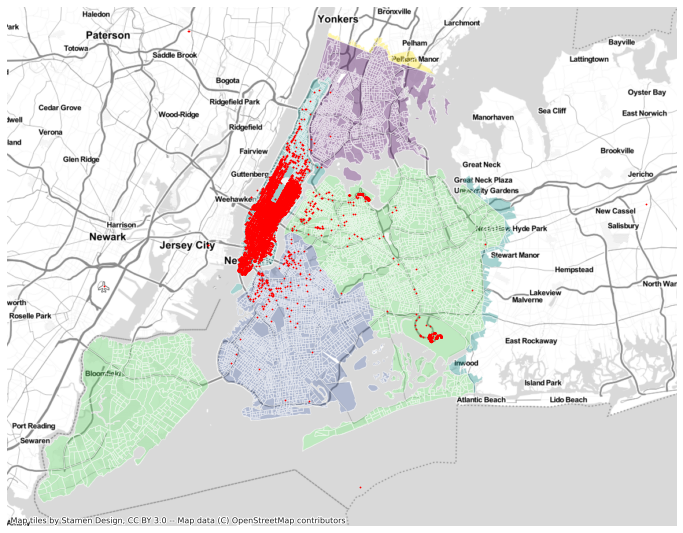

In [36]:
# Plot the census blocks
ax = census.plot(column = 'geoid', figsize=(12, 12), scheme='EqualInterval', alpha=.4, cmap='viridis')

# pickup points within blocks (red points)
pickup_jan.plot(ax=ax, color='red', markersize=.6)

# basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

ax.set_axis_off()
plt.show()

# simpe EDA to understand the data

In [37]:
# Let's build spatial index for pickup points
pickup_jan_sindex = pickup_jan.sindex

In [38]:
# Spatial join
pickup_blocks = gpd.sjoin(census, pickup_jan, how='inner', op='intersects')
print(pickup_blocks.shape)
pickup_blocks.head()

(9985, 4)


,geoid,geometry,index_right,pickup_time
112,360050063002,"POLYGON ((-8230189.145 4987003.974, -8230187.5...",7701,2015-01-01 15:26:17
112,360050063002,"POLYGON ((-8230189.145 4987003.974, -8230187.5...",6748,2015-01-01 15:23:14
112,360050063002,"POLYGON ((-8230189.145 4987003.974, -8230187.5...",6227,2015-01-01 15:21:29
363,360050185001,"POLYGON ((-8227823.272 4986773.446, -8227769.3...",331,2015-01-01 15:01:42
606,360050261001,"POLYGON ((-8227523.266 4992155.295, -8227490.2...",7337,2015-01-01 15:25:08


In [39]:
# Get the indices of the Points that are likely to be inside the bounding box
def get_points_within_blocks(block_df):
    matched_idx = []
    for block in block_df.itertuples():
        bounds = block.geometry.bounds
        points_idx = list(pickup_jan_sindex.intersection(bounds))
        matched_idx += points_idx

        # Get unique candidates
        unique_idx_matches = list(set(matched_idx))
        matches = pickup_jan.iloc[unique_idx_matches]

        # Conduct the actual intersect
        result = matches.loc[matches.intersects(pickup_blocks.unary_union)]
    return result

In [41]:
points_within_box = get_points_within_blocks(pickup_blocks[:5])
points_within_box

,pickup_time,pickup_point
7337,2015-01-01 15:25:08,POINT (-8227388.716 4992483.479)
331,2015-01-01 15:01:42,POINT (-8227387.017 4986768.877)
6227,2015-01-01 15:21:29,POINT (-8229911.138 4986335.085)
7701,2015-01-01 15:26:17,POINT (-8229955.302 4984880.089)
6748,2015-01-01 15:23:14,POINT (-8229522.158 4985738.583)


<AxesSubplot:>

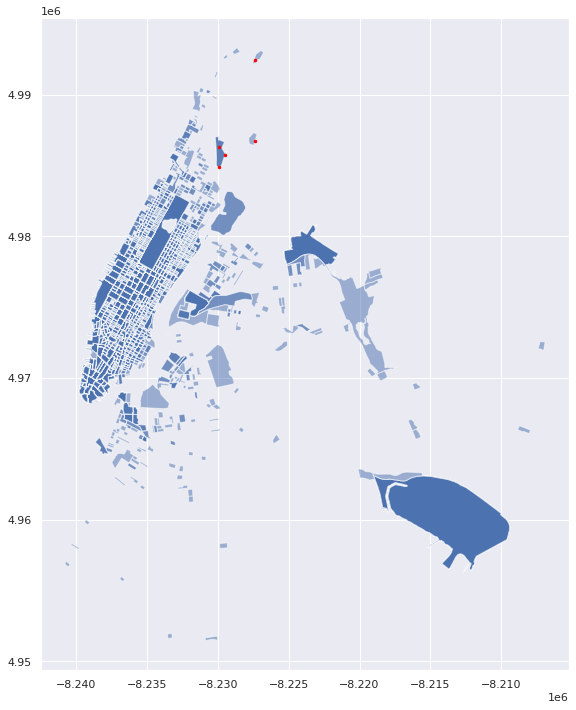

In [42]:
# Visualize
ax = pickup_blocks.plot(figsize=(12,12), alpha=0.5)
points_within_box.plot(ax=ax, color='red', markersize=6)

# Task: 
Merge the taxi and ACS dataset by block group and compute the average number of pickups by block group 

In [44]:
# Count how many pickups were made within each block
pickup_blocks.groupby('geoid').geoid.count().sort_values()

geoid
360050019001      1
360610215001      1
360610211006      1
360610211005      1
360610211004      1
               ... 
360610104001    280
360610143001    403
360810331001    489
360610101001    525
360810716001    526
Name: geoid, Length: 1212, dtype: int64

In [ ]:
# Count how many pickups were made within each block
pickup_blocks.groupby('geoid').pickup_time.value_counts()